In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import time
from spn_3.spn import SPN
from utils import train, count_parameters, apply_lth_pruning, clean_weights, merge_weights

In [2]:
# Set the seed for PyTorch (CPU and GPU)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
#hyperparameters
batch_size = 75
learning_rate = 0.001
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Get Dataset

In [4]:
# Load and preprocess the entire MNIST dataset once
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

num_classes = 10
MLP_hidden_dims = [12, 12]
total_nodes = sum(MLP_hidden_dims)
input_size = 784  # MNIST images are 28x28 pixels, flattened to 784

# Normalize the images to [0, 1] range
train_data = train_dataset.data.float().div(255).to(device)
test_data = test_dataset.data.float().div(255).to(device)

# Use integer labels for classification (not one-hot encoding)
train_labels = train_dataset.targets.to(device)
test_labels = test_dataset.targets.to(device)

# Create DataLoader from preloaded GPU tensors
batch_size = 64  # You can set this to whatever batch size you prefer
train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

num_samples = train_data.shape[0]

/ediss_data/ediss4/sarosh/anaconda3/envs/saroshgpu/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Minimal MLP

In [5]:
class Minimal_MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

MLP baseline

In [6]:
class MLP_MNIST(nn.Module):
    def __init__(self, input_size, hidden_dims, num_classes):
        super(MLP_MNIST, self).__init__()
        layers = []
        prev_dim = input_size
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [7]:
model_0 = Minimal_MLP(input_size, sum(MLP_hidden_dims), num_classes).cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)

In [9]:
param_count_0 = count_parameters(model_0)

In [10]:
train_metrics_0, val_metrics_0 = train(model_0, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.9001 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.8695 Train_Loss: 0.4991 Validation_Accuracy: 0.9276 Validation_Loss: 0.2553
Epoch: 2 Total_Time: 0.9043 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9339 Train_Loss: 0.2357 Validation_Accuracy: 0.9401 Validation_Loss: 0.2070
Epoch: 3 Total_Time: 0.9378 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9443 Train_Loss: 0.1956 Validation_Accuracy: 0.9470 Validation_Loss: 0.1842
Epoch: 4 Total_Time: 0.8824 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9509 Train_Loss: 0.1719 Validation_Accuracy: 0.9533 Validation_Loss: 0.1663
Epoch: 5 Total_Time: 0.8556 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9556 Train_Loss: 0.1554 Validation_Accuracy: 0.9562 Validation_Loss: 0.1577
Epoch: 6 Total_Time: 0.8514 Average_Time_per_batch: 0.0009 Train_Accuracy: 0.9583 Train_Loss: 0.1429 Validation_Accuracy: 0.9552 Validation_Loss: 0.1534
Epoch: 7 Total_Time: 0.8917 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9607

In [11]:
model_1 = MLP_MNIST(input_size, MLP_hidden_dims, num_classes).to(device)
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [12]:
param_count_1 = count_parameters(model_1)

In [13]:
train_metrics_1, val_metrics_1 = train(model_1, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 1.3955 Average_Time_per_batch: 0.0015 Train_Accuracy: 0.7828 Train_Loss: 0.7434 Validation_Accuracy: 0.8999 Validation_Loss: 0.3546
Epoch: 2 Total_Time: 1.1186 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.9057 Train_Loss: 0.3337 Validation_Accuracy: 0.9180 Validation_Loss: 0.2933
Epoch: 3 Total_Time: 1.2122 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9176 Train_Loss: 0.2883 Validation_Accuracy: 0.9218 Validation_Loss: 0.2747
Epoch: 4 Total_Time: 1.1458 Average_Time_per_batch: 0.0012 Train_Accuracy: 0.9242 Train_Loss: 0.2647 Validation_Accuracy: 0.9256 Validation_Loss: 0.2579
Epoch: 5 Total_Time: 1.2373 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9288 Train_Loss: 0.2475 Validation_Accuracy: 0.9330 Validation_Loss: 0.2421
Epoch: 6 Total_Time: 1.2570 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9322 Train_Loss: 0.2335 Validation_Accuracy: 0.9369 Validation_Loss: 0.2282
Epoch: 7 Total_Time: 1.2461 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.9356

Minimal SPN

In [14]:
model_2 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes).cuda()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [15]:
param_count_2 = model_2.count_parameters()

In [16]:
train_metrics_2, val_metrics_2 = train(model_2, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 0.9267 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.8860 Train_Loss: 0.4353 Validation_Accuracy: 0.9252 Validation_Loss: 0.2683
Epoch: 2 Total_Time: 0.9095 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9295 Train_Loss: 0.2506 Validation_Accuracy: 0.9366 Validation_Loss: 0.2197
Epoch: 3 Total_Time: 0.9828 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9431 Train_Loss: 0.1999 Validation_Accuracy: 0.9459 Validation_Loss: 0.1839
Epoch: 4 Total_Time: 0.9063 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9521 Train_Loss: 0.1662 Validation_Accuracy: 0.9566 Validation_Loss: 0.1539
Epoch: 5 Total_Time: 1.0453 Average_Time_per_batch: 0.0011 Train_Accuracy: 0.9579 Train_Loss: 0.1437 Validation_Accuracy: 0.9593 Validation_Loss: 0.1397
Epoch: 6 Total_Time: 0.9198 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9628 Train_Loss: 0.1269 Validation_Accuracy: 0.9602 Validation_Loss: 0.1345
Epoch: 7 Total_Time: 0.9298 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.9661

Maximal SPN

In [17]:
model_3 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [18]:
param_count_3 = model_3.count_parameters()

In [19]:
train_metrics_3, val_metrics_3 = train(model_3, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 15.4501 Average_Time_per_batch: 0.0165 Train_Accuracy: 0.8880 Train_Loss: 0.4196 Validation_Accuracy: 0.9194 Validation_Loss: 0.2722
Epoch: 2 Total_Time: 15.4870 Average_Time_per_batch: 0.0165 Train_Accuracy: 0.9299 Train_Loss: 0.2438 Validation_Accuracy: 0.9388 Validation_Loss: 0.2077
Epoch: 3 Total_Time: 16.0388 Average_Time_per_batch: 0.0171 Train_Accuracy: 0.9442 Train_Loss: 0.1934 Validation_Accuracy: 0.9487 Validation_Loss: 0.1757
Epoch: 4 Total_Time: 15.1379 Average_Time_per_batch: 0.0161 Train_Accuracy: 0.9532 Train_Loss: 0.1612 Validation_Accuracy: 0.9559 Validation_Loss: 0.1516
Epoch: 5 Total_Time: 14.3198 Average_Time_per_batch: 0.0153 Train_Accuracy: 0.9589 Train_Loss: 0.1408 Validation_Accuracy: 0.9572 Validation_Loss: 0.1448
Epoch: 6 Total_Time: 14.6281 Average_Time_per_batch: 0.0156 Train_Accuracy: 0.9627 Train_Loss: 0.1256 Validation_Accuracy: 0.9615 Validation_Loss: 0.1305
Epoch: 7 Total_Time: 15.0799 Average_Time_per_batch: 0.0161 Train_Accuracy:

Free Weights SPN

In [20]:
model_4 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False, hidden_dims = MLP_hidden_dims + [num_classes]).cuda()
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)

In [21]:
param_count_4 = model_4.count_parameters()

In [22]:
train_metrics_4, val_metrics_4 = train(model_4, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 1.4918 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.8844 Train_Loss: 0.4343 Validation_Accuracy: 0.9233 Validation_Loss: 0.2686
Epoch: 2 Total_Time: 1.5399 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9285 Train_Loss: 0.2508 Validation_Accuracy: 0.9394 Validation_Loss: 0.2152
Epoch: 3 Total_Time: 1.6370 Average_Time_per_batch: 0.0017 Train_Accuracy: 0.9432 Train_Loss: 0.2006 Validation_Accuracy: 0.9482 Validation_Loss: 0.1824
Epoch: 4 Total_Time: 1.5217 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9517 Train_Loss: 0.1673 Validation_Accuracy: 0.9521 Validation_Loss: 0.1674
Epoch: 5 Total_Time: 1.5345 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9575 Train_Loss: 0.1459 Validation_Accuracy: 0.9576 Validation_Loss: 0.1449
Epoch: 6 Total_Time: 1.5174 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9626 Train_Loss: 0.1286 Validation_Accuracy: 0.9608 Validation_Loss: 0.1335
Epoch: 7 Total_Time: 1.5264 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9667

Maximal SPN with pruning

In [23]:
model_5 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [24]:
percent = 0.99
rounds = 10
pruning_epochs = 3

pruning_start = time.time()
new_weights = apply_lth_pruning(model_5, train_loader, test_loader, pruning_epochs, optimizer, criterion, percent, rounds)
pruning_time = time.time() - pruning_start

Initial Validation Phase
Epoch: 1 Total_Time: 15.9184 Average_Time_per_batch: 0.0170 Train_Accuracy: 0.8868 Train_Loss: 0.4202 Validation_Accuracy: 0.9221 Validation_Loss: 0.2723
Epoch: 2 Total_Time: 14.7051 Average_Time_per_batch: 0.0157 Train_Accuracy: 0.9291 Train_Loss: 0.2454 Validation_Accuracy: 0.9372 Validation_Loss: 0.2189
Epoch: 3 Total_Time: 16.2195 Average_Time_per_batch: 0.0173 Train_Accuracy: 0.9424 Train_Loss: 0.1965 Validation_Accuracy: 0.9478 Validation_Loss: 0.1795

Pruning Round: 1
Epoch: 1 Total_Time: 15.1263 Average_Time_per_batch: 0.0161 Train_Accuracy: 0.8904 Train_Loss: 0.4099 Validation_Accuracy: 0.9187 Validation_Loss: 0.2882
Epoch: 2 Total_Time: 15.2842 Average_Time_per_batch: 0.0163 Train_Accuracy: 0.9265 Train_Loss: 0.2614 Validation_Accuracy: 0.9351 Validation_Loss: 0.2239
Epoch: 3 Total_Time: 15.3170 Average_Time_per_batch: 0.0163 Train_Accuracy: 0.9415 Train_Loss: 0.2023 Validation_Accuracy: 0.9485 Validation_Loss: 0.1763

Pruning Round: 2
Epoch: 1 Total_

In [25]:
cleaned_weights = clean_weights(new_weights, input_size)
merged_weights = merge_weights(cleaned_weights, input_size, num_classes)

Empty Blocks:  []


In [26]:
hidden_dims_pruned = [weight.shape[0] for weight in merged_weights]
print("Pruned Dimensions: ", hidden_dims_pruned)
print("Pruning Time: ", pruning_time)

Pruned Dimensions:  [19, 5, 10]
Pruning Time:  598.5451428890228


In [27]:
model_5 = SPN(input_size, sum(hidden_dims_pruned), num_classes, minimal=False, hidden_dims=hidden_dims_pruned).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [28]:
param_count_5 = model_5.count_parameters()

In [29]:
train_metrics_5, val_metrics_5 = train(model_5, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 1.5275 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.8917 Train_Loss: 0.4188 Validation_Accuracy: 0.9280 Validation_Loss: 0.2490
Epoch: 2 Total_Time: 1.5447 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9352 Train_Loss: 0.2284 Validation_Accuracy: 0.9414 Validation_Loss: 0.1955
Epoch: 3 Total_Time: 1.6401 Average_Time_per_batch: 0.0017 Train_Accuracy: 0.9468 Train_Loss: 0.1836 Validation_Accuracy: 0.9515 Validation_Loss: 0.1702
Epoch: 4 Total_Time: 1.5261 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9547 Train_Loss: 0.1560 Validation_Accuracy: 0.9564 Validation_Loss: 0.1532
Epoch: 5 Total_Time: 1.5426 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9596 Train_Loss: 0.1372 Validation_Accuracy: 0.9579 Validation_Loss: 0.1445
Epoch: 6 Total_Time: 1.5325 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9640 Train_Loss: 0.1235 Validation_Accuracy: 0.9617 Validation_Loss: 0.1339
Epoch: 7 Total_Time: 1.5445 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.9674

Plot Training and Test Accuracies Across Epochs

In [30]:
import numpy as np
import matplotlib.pyplot as plt

train_acc_0 = train_metrics_0[:, 2] / (num_samples / batch_size)
train_acc_1 = train_metrics_1[:, 2] / (num_samples / batch_size)
train_acc_2 = train_metrics_2[:, 2] / (num_samples / batch_size)
train_acc_3 = train_metrics_3[:, 2] / (num_samples / batch_size)
train_acc_4 = train_metrics_4[:, 2] / (num_samples / batch_size)
train_acc_5 = train_metrics_5[:, 2] / (num_samples / batch_size)

epochs = np.arange(1, epochs + 1)

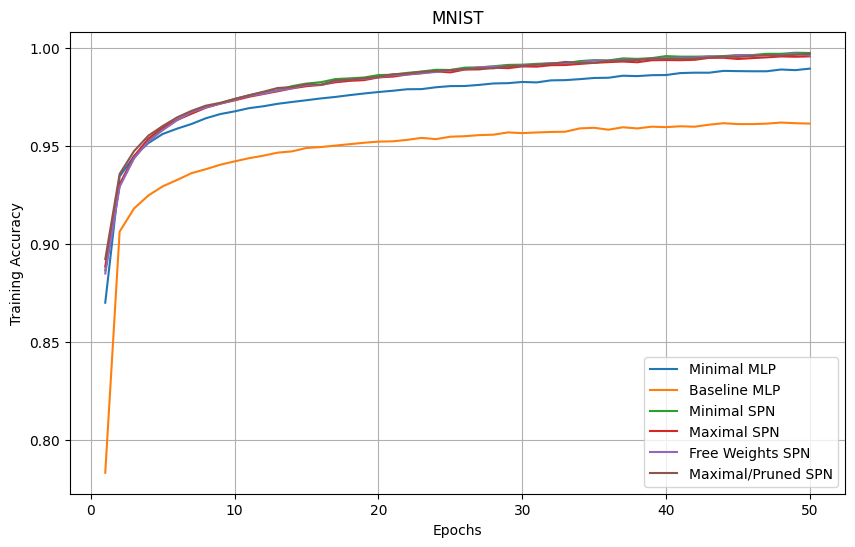

In [31]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_acc_0, label='Minimal MLP')
plt.plot(epochs, train_acc_1, label='Baseline MLP')
plt.plot(epochs, train_acc_2, label='Minimal SPN')
plt.plot(epochs, train_acc_3, label='Maximal SPN')
plt.plot(epochs, train_acc_4, label='Free Weights SPN')
plt.plot(epochs, train_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('MNIST')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/MNIST/training_accuracy_plot.png')  # Save as PNG file
plt.show()

In [32]:
test_acc_0 = val_metrics_0[:, 1]
test_acc_1 = val_metrics_1[:, 1]
test_acc_2 = val_metrics_2[:, 1]
test_acc_3 = val_metrics_3[:, 1]
test_acc_4 = val_metrics_4[:, 1]
test_acc_5 = val_metrics_5[:, 1]

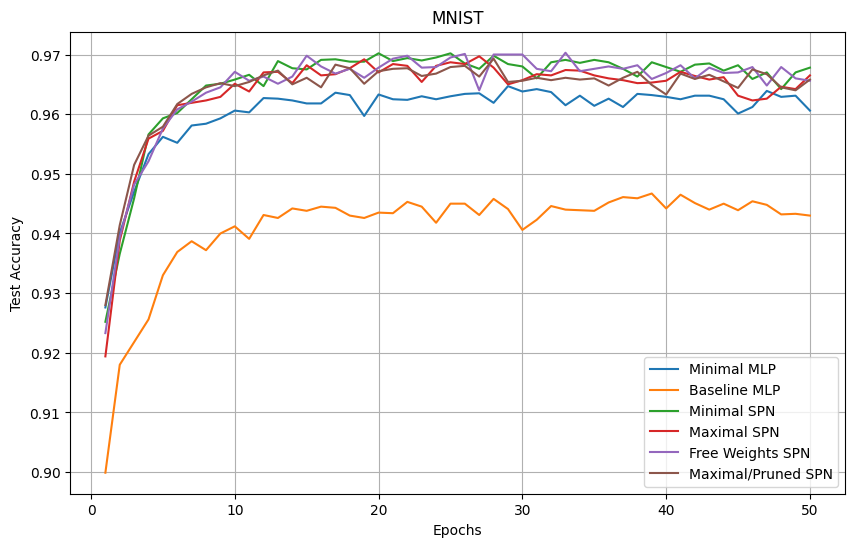

In [33]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_acc_0, label='Minimal MLP')
plt.plot(epochs, test_acc_1, label='Baseline MLP')
plt.plot(epochs, test_acc_2, label='Minimal SPN')
plt.plot(epochs, test_acc_3, label='Maximal SPN')
plt.plot(epochs, test_acc_4, label='Free Weights SPN')
plt.plot(epochs, test_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('MNIST')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/MNIST/test_accuracy_plot.png')  # Save as PNG file
plt.show()

Get efficiency of each model

In [34]:
# List of all test accuracies
test_accuracies = [test_acc_0, test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Find the index of the best (maximum) accuracy for each model
best_accuracy_indices = [np.argmax(acc) + 1 for acc in test_accuracies]

In [35]:
time_to_best_acc_0 = train_metrics_0[:best_accuracy_indices[0], 0].sum()
time_to_best_acc_1 = train_metrics_1[:best_accuracy_indices[1], 0].sum()
time_to_best_acc_2 = train_metrics_2[:best_accuracy_indices[2], 0].sum()
time_to_best_acc_3 = train_metrics_3[:best_accuracy_indices[3], 0].sum()
time_to_best_acc_4 = train_metrics_4[:best_accuracy_indices[4], 0].sum()
time_to_best_acc_5 = train_metrics_5[:best_accuracy_indices[5], 0].sum()

best_test_acc_0 = test_acc_0[best_accuracy_indices[0] - 1]
best_test_acc_1 = test_acc_1[best_accuracy_indices[1] - 1]
best_test_acc_2 = test_acc_2[best_accuracy_indices[2] - 1]
best_test_acc_3 = test_acc_3[best_accuracy_indices[3] - 1]
best_test_acc_4 = test_acc_4[best_accuracy_indices[4] - 1]
best_test_acc_5 = test_acc_5[best_accuracy_indices[5] - 1]

In [36]:
summary_0 = ['Minimal MLP', param_count_0, best_test_acc_0, time_to_best_acc_0, best_test_acc_0 / time_to_best_acc_0]
summary_1 = ['Baseline MLP', param_count_1, best_test_acc_1, time_to_best_acc_1, best_test_acc_1 / time_to_best_acc_1]
summary_2 = ['Minimal SPN', param_count_2, best_test_acc_2, time_to_best_acc_2, best_test_acc_2 / time_to_best_acc_2]
summary_3 = ['Maximal SPN', param_count_3, best_test_acc_3, time_to_best_acc_3, best_test_acc_3 / time_to_best_acc_3]
summary_4 = ['Free Weights SPN', param_count_4, best_test_acc_4, time_to_best_acc_4, best_test_acc_4 / time_to_best_acc_4]
summary_5 = ['Maximal/Pruned SPN', param_count_5, best_test_acc_5, time_to_best_acc_5, best_test_acc_5 / time_to_best_acc_5]

In [37]:
import pandas as pd

# Combine all summaries into a list of lists (each summary as a row)
summaries = [summary_0, summary_1, summary_2, summary_3, summary_4, summary_5]

# Create a DataFrame
df = pd.DataFrame(summaries, columns=['Model', 'Parameter Count', 'Best Test Accuracy', 'Time to Best Test Accuracy', 'Efficiency'])

# Set the display options to allow for better fitting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width so it can fit more columns
pd.set_option('display.max_colwidth', None)  # Allow unlimited column width

# Now when you print the DataFrame, it will be displayed as a continuous table
print(df)

                Model  Parameter Count  Best Test Accuracy  Time to Best Test Accuracy  Efficiency
0         Minimal MLP            19090              0.9647                   25.492456    0.037843
1        Baseline MLP             9706              0.9467                   47.006294    0.020140
2         Minimal SPN            26930              0.9702                   18.733570    0.051789
3         Maximal SPN            27251              0.9697                  414.544816    0.002339
4    Free Weights SPN            27074              0.9703                   50.772609    0.019111
5  Maximal/Pruned SPN            27025              0.9693                   44.014118    0.022022


In [38]:
df.to_csv('results/MNIST/model_summary.csv', index=False)